In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
import tqdm
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [3]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [72]:
now = pd.Timestamp.now()
pdFilter = 'jsonPayload.method="submitNewBlock" AND "received block from builder" ' + \
           'AND jsonPayload.builderPubkey="0xa00000a975dffbd1ef61953ac6c90b52b70eb0188eb9d030774346c9248f81e875f7e8bc56c4bbbda297a9543cfa051d" ' + \
           'AND timestamp>=' + '\"' + (now - pd.Timedelta('5h')).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
           'AND timestamp<=' + '\"' + (now).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'

In [73]:
payloads = []
for e in client.list_entries(filter_=pdFilter):
    payloads.append(e.to_api_repr()['jsonPayload'])
payloads = pd.DataFrame(payloads)

In [74]:
payloads = pd.DataFrame(payloads)

In [75]:
len(payloads), payloads.keys()

(8654,
 Index(['proposerPubkey', 'timestampBeforeSignatureCheck', 'wasBidSavedInRedis',
        'fastTrackValidation', 'timestampAfterBidUpdate', 'method',
        'timestampRequestStart', 'prevTopBidValue', 'topBidValue',
        'timestampAfterChecks1', 'slot', 'timestampBeforeAttributesCheck',
        'payloadBytes', 'profilePrechecksUs', 'wasTopBidUpdated', 'parentHash',
        'headSlot', 'version', 'profileRedisUpdateTopBidUs',
        'profileRedisSavePayloadUs', 'profileSimUs', 'builderIsHighPrio',
        'level', 'newBidIsTopBid', 'builderPubkey', 'value', 'profileTotalUs',
        'reqContentType', 'timestampEligibleAt', 'blockHash',
        'timestampBeforeValidation', 'timestampAfterDecoding', 'contentLength',
        'profileDecodeUs', 'floorBidValue', 'service', 'reqIsGzip',
        'profileRedisUs', 'timestampAfterSignatureCheck', 'numTx', 'msg',
        'profileRedisUpdateFloorUs', 'cancellationEnabled', 'isLargeRequest',
        'validationDurationMs', 'timestampAfte

In [60]:
ssz = payloads[payloads['reqContentType'] == 'ssz']
json = payloads[payloads['reqContentType'] == 'json']
len(ssz), len(json)

(0, 10059)

In [61]:
bn = payloads[payloads['builderPubkey']=='0x8000008a03ebae7d8ab2f66659bd719a698b2e74097d1e423df85e0d58571140527c15052a36c19878018aaebe8a6fea']
ssz = bn[bn['reqContentType'] == 'ssz']
json = bn[bn['reqContentType'] == 'json']
len(ssz), len(json)

(0, 10059)

In [76]:
bn2 = payloads[payloads['builderPubkey']=='0xa00000a975dffbd1ef61953ac6c90b52b70eb0188eb9d030774346c9248f81e875f7e8bc56c4bbbda297a9543cfa051d']
ssz2 = bn2[bn2['reqContentType'] == 'ssz']
json2 = bn2[bn2['reqContentType'] == 'json']
len(ssz2), len(json2)

(0, 8654)

Text(0.5, 1.0, 'time to decode payload')

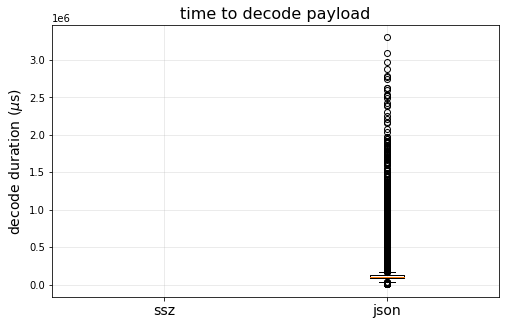

In [62]:
f, ax = plt.subplots(figsize=(8,5))
ax.boxplot([ssz.profileDecodeUs, json.profileDecodeUs])
ax.set_xticklabels(['ssz', 'json'], size=14)
ax.set_ylabel('decode duration ($\mu$s)', size=14)
ax.set_title('time to decode payload', size=16)

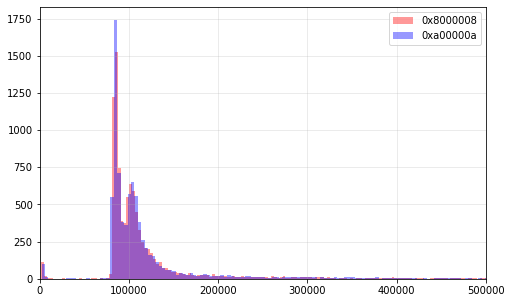

In [79]:
f, ax = plt.subplots(figsize=(8,5))
ax.hist(json.profileDecodeUs, bins=1000, color='r', alpha=0.4, label='0x8000008')
ax.hist(json2.profileDecodeUs, bins=1000, color='b', alpha=0.4, label='0xa00000a')
ax.set_xlim(0,500000)
ax.legend()
plt.show()

In [65]:
print('decode\_duration & ', end='')
st = ''
for i in [50, 75, 90, 99]:
    st += str(int(np.percentile(json.profileDecodeUs, i)))
    st += " & "
print(st)

decode\_duration & 100657 & 121408 & 242436 & 1342960 & 


Text(0.5, 1.0, 'time to decode payload')

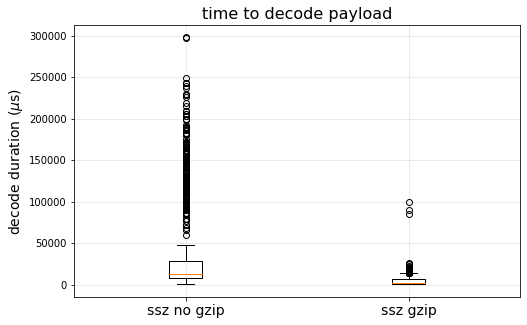

In [40]:
f, ax = plt.subplots(figsize=(8,5))
ax.boxplot([ssz[ssz.reqIsGzip==False].profileDecodeUs, ssz[ssz.reqIsGzip==True].profileDecodeUs])
ax.set_xticklabels(['ssz no gzip', 'ssz gzip'], size=14)
ax.set_ylabel('decode duration ($\mu$s)', size=14)
ax.set_title('time to decode payload', size=16)